In [1]:
# @title Mount Drive & Extract Dataset
from google.colab import drive
drive.mount('/content/drive')

import os
import zipfile

DRIVE_PATH = '/content/drive/MyDrive/ML Project/'
DATASET_ZIP_PATH = DRIVE_PATH + 'AML_project_herbarium_dataset.zip'
EXTRACT_PATH = '/content/dataset/'
TRAIN_ANNOTATIONS = EXTRACT_PATH + 'list/train.txt'
TEST_ANNOTATIONS = EXTRACT_PATH + 'list/test.txt'
GROUNDTRUTH_FILE = EXTRACT_PATH + 'list/groundtruth.txt'
SPECIES_LIST = EXTRACT_PATH + 'list/species_list.txt'
CLASS_WITH_PAIRS = EXTRACT_PATH + 'list/class_with_pairs.txt'
CLASS_WITHOUT_PAIRS = EXTRACT_PATH + 'list/class_without_pairs.txt'
WEIGHTS_PATH = DRIVE_PATH + 'pseudo-labelling_model_weights.pth'
RESULTS_PATH = DRIVE_PATH + 'results_pseudo-labelling/'

os.makedirs(RESULTS_PATH, exist_ok=True)

def extract_zip(zip_path, extract_to):
    if not os.path.exists(extract_to):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Extracted {zip_path} to {extract_to}")
    else:
        print(f"Dataset already extracted at {extract_to}")

extract_zip(DATASET_ZIP_PATH, EXTRACT_PATH)

Mounted at /content/drive
Extracted /content/drive/MyDrive/ML Project/AML_project_herbarium_dataset.zip to /content/dataset/


In [2]:
# @title Install Required Packages
!pip install -q torch torchvision torchaudio
!pip install -q kagglehub
!pip install -q timm
!pip install -q albumentations

In [3]:
# @title Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import time
from collections import defaultdict
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# @title Load DINOv2 Backbone
import kagglehub

# Download DINOv2 model
model_dir = kagglehub.model_download("juliostat/dinov2_patch14_reg4_onlyclassifier_then_all/PyTorch/default")
print(f"Model downloaded to: {model_dir}")

# Load pre-trained DINOv2
try:
    dinov2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
except:
    # Fallback if hub doesn't work
    import timm
    dinov2_model = timm.create_model('vit_base_patch14_dinov2.lvd142m', pretrained=True)

dinov2_model = dinov2_model.to(device)
dinov2_model.eval()

# Freeze DINOv2 - we only use it as feature extractor
for param in dinov2_model.parameters():
    param.requires_grad = False

print("DINOv2 loaded and frozen for feature extraction")

Model downloaded to: /kaggle/input/dinov2_patch14_reg4_onlyclassifier_then_all/pytorch/default/3
Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth


100%|██████████| 330M/330M [00:01<00:00, 270MB/s]


DINOv2 loaded and frozen for feature extraction


In [5]:
# @title Load Dataset Annotations
def load_annotations(annotation_file):
    """Load image paths and labels from annotation file"""
    data = []
    with open(annotation_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                img_path, label = parts
                data.append((img_path, int(label)))
    return data

def load_groundtruth(groundtruth_file):
    """Load test groundtruth"""
    gt = {}
    with open(groundtruth_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                img_path, label = parts
                gt[img_path] = int(label)
    return gt

def load_class_list(class_file):
    """Load list of class IDs"""
    classes = []
    with open(class_file, 'r') as f:
        for line in f:
            classes.append(int(line.strip()))
    return set(classes)

# Load all annotations
train_data = load_annotations(TRAIN_ANNOTATIONS)

# Load test data - read image paths from test.txt
test_data = []
with open(TEST_ANNOTATIONS, 'r') as f:
    for line in f:
        img_path = line.strip()
        if img_path:
            test_data.append((img_path, -1))  # -1 as placeholder label

test_groundtruth = load_groundtruth(GROUNDTRUTH_FILE)
classes_with_pairs = load_class_list(CLASS_WITH_PAIRS)
classes_without_pairs = load_class_list(CLASS_WITHOUT_PAIRS)

# Separate train data by domain and pairing
herbarium_data = [d for d in train_data if 'herbarium' in d[0]]
field_data = [d for d in train_data if 'photo' in d[0]]

# Get all unique labels in training data
unique_train_labels = set([label for _, label in train_data])

print(f"Total training samples: {len(train_data)}")
print(f"  - Herbarium: {len(herbarium_data)}")
print(f"  - Field: {len(field_data)}")
print(f"Unique labels in training data: {len(unique_train_labels)}")
print(f"  - Sample labels: {sorted(list(unique_train_labels))[:10]}")
print(f"Classes with pairs: {len(classes_with_pairs)}")
print(f"  - Sample paired classes: {sorted(list(classes_with_pairs))[:10]}")
print(f"Classes without pairs: {len(classes_without_pairs)}")
print(f"  - Sample unpaired classes: {sorted(list(classes_without_pairs))[:10]}")
print(f"Test samples: {len(test_data)}")

Total training samples: 4744
  - Herbarium: 3700
  - Field: 1044
Unique labels in training data: 100
  - Sample labels: [12254, 12518, 12910, 12922, 13276, 13325, 13330, 13370, 14353, 14401]
Classes with pairs: 60
  - Sample paired classes: [12518, 12910, 12922, 13330, 13370, 14353, 15318, 15355, 19165, 19489]
Classes without pairs: 40
  - Sample unpaired classes: [12254, 13276, 13325, 14401, 15014, 15330, 105951, 106387, 106466, 116853]
Test samples: 207


In [6]:
# @title Define Data Augmentations
# Herbarium augmentations (stronger since they need to simulate field conditions)
herbarium_transforms = A.Compose([
    A.Resize(518, 518),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    A.GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.3),
    A.Affine(scale=(0.8, 1.2), translate_percent=(-0.1, 0.1), rotate=(-15, 15), shear=(-5, 5), p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Field augmentations (lighter, preserve natural appearance)
field_transforms = A.Compose([
    A.Resize(518, 518),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Test transforms (no augmentation)
test_transforms = A.Compose([
    A.Resize(518, 518),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

/tmp/ipython-input-2757309623.py:11: UserWarning: Argument(s) 'var_limit, mean' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.3),


In [7]:
# @title Custom Dataset Class
class PlantDataset(Dataset):
    def __init__(self, data_list, root_path, transform=None, return_domain=False):
        self.data_list = data_list
        self.root_path = root_path
        self.transform = transform
        self.return_domain = return_domain

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        full_path = os.path.join(self.root_path, img_path)

        # Load image
        image = Image.open(full_path).convert('RGB')
        image = np.array(image)

        # Apply transforms
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
        else:
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0

        if self.return_domain:
            # Domain: 0 = herbarium, 1 = field
            domain = 1 if 'photo' in img_path else 0
            return image, label, domain

        return image, label

In [8]:
# @title Extract DINOv2 Features (Run Once)
FEATURES_PATH = DRIVE_PATH + 'dinov2_features.pt'

def extract_features(model, dataloader, desc="Extracting features"):
    """Extract features from DINOv2 for entire dataset"""
    features_list = []
    labels_list = []
    domains_list = []

    model.eval()
    with torch.no_grad():
        for images, labels, domains in tqdm(dataloader, desc=desc):
            images = images.to(device)
            features = model(images)  # [batch, 768]
            features_list.append(features.cpu())
            labels_list.append(labels)
            domains_list.append(domains)

    features = torch.cat(features_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    domains = torch.cat(domains_list, dim=0)

    return features, labels, domains

# Check if features already extracted
if os.path.exists(FEATURES_PATH):
    print("Loading pre-extracted features...")
    feature_data = torch.load(FEATURES_PATH)
    train_features = feature_data['features']
    train_labels = feature_data['labels']
    train_domains = feature_data['domains']
    print(f"Loaded features: {train_features.shape}")
else:
    print("Extracting features from DINOv2...")

    # Create combined dataset with domain labels
    train_dataset = PlantDataset(
        train_data,
        EXTRACT_PATH,
        transform=herbarium_transforms,  # Use one transform for extraction
        return_domain=True
    )

    train_loader_extract = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    train_features, train_labels, train_domains = extract_features(
        dinov2_model,
        train_loader_extract,
        desc="Extracting training features"
    )

    # Save features
    torch.save({
        'features': train_features,
        'labels': train_labels,
        'domains': train_domains
    }, FEATURES_PATH)

    print(f"Features extracted and saved: {train_features.shape}")

# Extract test features
TEST_FEATURES_PATH = DRIVE_PATH + 'dinov2_test_features.pt'

if os.path.exists(TEST_FEATURES_PATH):
    print("Loading pre-extracted test features...")
    test_feature_data = torch.load(TEST_FEATURES_PATH)
    test_features = test_feature_data['features']
    test_paths = test_feature_data['paths']
else:
    print("Extracting test features...")
    test_dataset = PlantDataset(
        test_data,
        EXTRACT_PATH,
        transform=test_transforms,
        return_domain=False
    )

    test_loader_extract = DataLoader(
        test_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    test_features_list = []
    with torch.no_grad():
        for images, _ in tqdm(test_loader_extract, desc="Extracting test features"):
            images = images.to(device)
            features = dinov2_model(images)
            test_features_list.append(features.cpu())

    test_features = torch.cat(test_features_list, dim=0)
    test_paths = [img_path for img_path, _ in test_data]

    torch.save({
        'features': test_features,
        'paths': test_paths
    }, TEST_FEATURES_PATH)

    print(f"Test features extracted: {test_features.shape}")

Extracting features from DINOv2...


Extracting training features: 100%|██████████| 149/149 [07:36<00:00,  3.06s/it]


Features extracted and saved: torch.Size([4744, 768])
Extracting test features...


Extracting test features: 100%|██████████| 7/7 [00:20<00:00,  2.97s/it]

Test features extracted: torch.Size([207, 768])


In [9]:
# @title Gradient Reversal Layer for DANN
class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_, None

class GradientReversalLayer(nn.Module):
    def __init__(self):
        super(GradientReversalLayer, self).__init__()

    def forward(self, x, lambda_=1.0):
        return GradientReversalFunction.apply(x, lambda_)

In [10]:
# @title Domain Discriminator
class DomainDiscriminator(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=128):
        super(DomainDiscriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 2)  # Binary: herbarium vs field
        )

    def forward(self, x):
        return self.net(x)

In [11]:
# @title ArcFace Layer
class ArcFaceLayer(nn.Module):
    def __init__(self, in_features, out_features, s=20.0, m=0.3):
        super(ArcFaceLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m

        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, features, labels=None):
        # Normalize features and weights
        features = F.normalize(features, p=2, dim=1)
        weight = F.normalize(self.weight, p=2, dim=1)

        # Cosine similarity
        cosine = F.linear(features, weight)

        if labels is not None and self.training:
            # Get angle
            theta = torch.acos(torch.clamp(cosine, -1.0 + 1e-7, 1.0 - 1e-7))

            # Add margin to target class
            target_theta = theta.gather(1, labels.view(-1, 1))
            target_theta = target_theta + self.m

            # Convert back to cosine
            cosine_with_margin = torch.cos(target_theta)

            # Replace target class with margin version
            one_hot = torch.zeros_like(cosine)
            one_hot.scatter_(1, labels.view(-1, 1), 1.0)

            output = (one_hot * cosine_with_margin) + ((1.0 - one_hot) * cosine)
            output = output * self.s
        else:
            output = cosine * self.s

        return output

In [12]:
# @title Complete Model Architecture
class PlantIdentificationModel(nn.Module):
    def __init__(self, input_dim=768, num_classes=100, hidden_dim=128):
        super(PlantIdentificationModel, self).__init__()

        # Gradient Reversal Layer
        self.grl = GradientReversalLayer()

        # Domain Discriminator
        self.domain_discriminator = DomainDiscriminator(input_dim, hidden_dim)

        # ArcFace Classifier
        self.arcface = ArcFaceLayer(input_dim, num_classes, s=20.0, m=0.3)

    def forward(self, features, labels=None, lambda_adv=1.0):
        # Species classification with ArcFace
        class_output = self.arcface(features, labels)

        # Domain classification with gradient reversal
        reversed_features = self.grl(features, lambda_adv)
        domain_output = self.domain_discriminator(reversed_features)

        return class_output, domain_output

In [13]:
# @title Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [14]:
# @title Combined Loss Function
class CombinedLoss(nn.Module):
    def __init__(self, num_classes, lambda_focal=0.2, lambda_adv=0.3):
        super(CombinedLoss, self).__init__()
        self.focal_loss = FocalLoss(alpha=0.25, gamma=2.0)
        self.ce_loss = nn.CrossEntropyLoss()
        self.lambda_focal = lambda_focal
        self.lambda_adv = lambda_adv

    def forward(self, class_output, domain_output, class_labels, domain_labels, is_pseudo=None):
        # Classification loss (ArcFace already includes margin)
        arcface_loss = self.ce_loss(class_output, class_labels)

        # Focal loss component
        focal = self.focal_loss(class_output, class_labels)

        # Domain adversarial loss
        domain_loss = self.ce_loss(domain_output, domain_labels)

        # Combine losses
        total_loss = arcface_loss + self.lambda_focal * focal + self.lambda_adv * domain_loss

        # Reduce weight for pseudo-labeled samples
        if is_pseudo is not None:
            weight_mask = torch.where(
                is_pseudo,
                torch.tensor(0.5, device=class_output.device),
                torch.tensor(1.0, device=class_output.device)
            )
            total_loss = total_loss * weight_mask.mean()

        return total_loss, {
            'arcface': arcface_loss.item(),
            'focal': focal.item(),
            'domain': domain_loss.item(),
            'total': total_loss.item()
        }

In [15]:
# @title Feature Dataset (for training on extracted features)
class FeatureDataset(Dataset):
    def __init__(self, features, labels, domains, pseudo_mask=None):
        self.features = features
        self.labels = labels
        self.domains = domains
        self.pseudo_mask = pseudo_mask if pseudo_mask is not None else torch.zeros(len(labels), dtype=torch.bool)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return (
            self.features[idx],
            self.labels[idx],
            self.domains[idx],
            self.pseudo_mask[idx]
        )

In [16]:
# @title Train One Epoch
def train_epoch(model, dataloader, criterion, optimizer, scaler, epoch, lambda_adv):
    model.train()

    total_loss = 0
    arcface_losses = []
    focal_losses = []
    domain_losses = []

    pbar = tqdm(dataloader, desc=f"Epoch {epoch}")
    for features, labels, domains, is_pseudo in pbar:
        features = features.to(device)
        labels = labels.to(device)
        domains = domains.to(device)
        is_pseudo = is_pseudo.to(device)

        optimizer.zero_grad()

        # Mixed precision training
        with torch.amp.autocast('cuda'):
            class_output, domain_output = model(features, labels, lambda_adv)
            loss, loss_dict = criterion(
                class_output, domain_output,
                labels, domains, is_pseudo
            )

        # Backward pass with gradient scaling and clipping
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        arcface_losses.append(loss_dict['arcface'])
        focal_losses.append(loss_dict['focal'])
        domain_losses.append(loss_dict['domain'])

        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'arcface': f"{loss_dict['arcface']:.4f}",
            'focal': f"{loss_dict['focal']:.4f}",
            'domain': f"{loss_dict['domain']:.4f}"
        })

    avg_loss = total_loss / len(dataloader)
    return {
        'total': avg_loss,
        'arcface': np.mean(arcface_losses),
        'focal': np.mean(focal_losses),
        'domain': np.mean(domain_losses)
    }

In [17]:
# @title Generate Pseudo Labels
def generate_pseudo_labels(model, herbarium_features, herbarium_labels, herbarium_indices, confidence_threshold=0.85):
    """Generate pseudo-labels for herbarium-only species"""
    model.eval()

    pseudo_labels = []
    pseudo_indices = []
    confidences = []

    with torch.no_grad():
        # Process in batches
        batch_size = 64
        for i in range(0, len(herbarium_features), batch_size):
            batch_features = herbarium_features[i:i+batch_size].to(device)
            batch_labels = herbarium_labels[i:i+batch_size]

            # Get predictions
            class_output, _ = model(batch_features, lambda_adv=0.0)
            probs = F.softmax(class_output, dim=1)

            max_probs, pred_labels = torch.max(probs, dim=1)

            # Keep high-confidence predictions
            for j, (prob, pred_label, true_label) in enumerate(zip(max_probs, pred_labels, batch_labels)):
                if prob.item() > confidence_threshold:
                    global_idx = herbarium_indices[i + j]
                    pseudo_labels.append(pred_label.item())
                    pseudo_indices.append(global_idx)
                    confidences.append(prob.item())

    print(f"Generated {len(pseudo_labels)} pseudo-labels with confidence > {confidence_threshold}")
    print(f"Average confidence: {np.mean(confidences):.4f}")

    return pseudo_indices, pseudo_labels, confidences

In [18]:
# @title Validate & Evaluate (Paired vs Unpaired)
def evaluate(model, test_features, test_paths, test_groundtruth, classes_with_pairs, classes_without_pairs, label_to_idx, idx_to_label, top_k=[1, 5]):
    """Evaluate model and report metrics for paired vs unpaired classes"""
    model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        batch_size = 64
        for i in range(0, len(test_features), batch_size):
            batch_features = test_features[i:i+batch_size].to(device)
            class_output, _ = model(batch_features, lambda_adv=0.0)

            # Get top-k predictions
            _, top_k_preds = torch.topk(class_output, max(top_k), dim=1)
            all_predictions.append(top_k_preds.cpu())

    all_predictions = torch.cat(all_predictions, dim=0)

    # Convert predictions from remapped indices back to original labels
    all_predictions_original = torch.zeros_like(all_predictions)
    for i in range(all_predictions.shape[0]):
        for j in range(all_predictions.shape[1]):
            remapped_idx = all_predictions[i, j].item()
            if remapped_idx in idx_to_label:
                all_predictions_original[i, j] = idx_to_label[remapped_idx]
            else:
                all_predictions_original[i, j] = -1

    # Get ground truth labels (original labels)
    for path in test_paths:
        label = test_groundtruth.get(path, -1)
        all_labels.append(label)

    all_labels = torch.tensor(all_labels)

    # Calculate overall accuracy
    results = {}
    for k in top_k:
        correct = 0
        for pred, label in zip(all_predictions_original, all_labels):
            if label in pred[:k]:
                correct += 1
        accuracy = correct / len(all_labels) * 100
        results[f'top{k}'] = accuracy
        print(f"Top-{k} Accuracy: {accuracy:.2f}%")

    # Calculate accuracy for paired vs unpaired classes
    paired_correct = {k: 0 for k in top_k}
    unpaired_correct = {k: 0 for k in top_k}
    paired_total = 0
    unpaired_total = 0

    for pred, label in zip(all_predictions_original, all_labels):
        if label.item() in classes_with_pairs:
            paired_total += 1
            for k in top_k:
                if label in pred[:k]:
                    paired_correct[k] += 1
        elif label.item() in classes_without_pairs:
            unpaired_total += 1
            for k in top_k:
                if label in pred[:k]:
                    unpaired_correct[k] += 1

    print("\n--- Performance on Classes WITH Herbarium-Field Pairs ---")
    for k in top_k:
        acc = paired_correct[k] / paired_total * 100 if paired_total > 0 else 0
        results[f'paired_top{k}'] = acc
        print(f"Top-{k} Accuracy: {acc:.2f}% ({paired_correct[k]}/{paired_total})")

    print("\n--- Performance on Classes WITHOUT Herbarium-Field Pairs ---")
    for k in top_k:
        acc = unpaired_correct[k] / unpaired_total * 100 if unpaired_total > 0 else 0
        results[f'unpaired_top{k}'] = acc
        print(f"Top-{k} Accuracy: {acc:.2f}% ({unpaired_correct[k]}/{unpaired_total})")

    return results

In [19]:
# @title Initialize Model and Training Components
# Get all unique labels and create a mapping to contiguous indices
unique_labels = sorted(set(train_labels.numpy().tolist()))
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# Remap labels to contiguous range [0, num_classes-1]
train_labels_remapped = torch.tensor([label_to_idx[label.item()] for label in train_labels])
num_classes = len(unique_labels)

print(f"Number of classes: {num_classes}")
print(f"Original label range: [{min(unique_labels)}, {max(unique_labels)}]")
print(f"Remapped label range: [0, {num_classes-1}]")

# Debug: Check label distribution
print(f"\nLabel Analysis:")
print(f"  - Sample original labels: {unique_labels[:20]}")
print(f"  - Classes with pairs: {sorted(list(classes_with_pairs))[:20]}...")
print(f"  - Overlap check: {len(set(unique_labels) & classes_with_pairs)} classes match")

# Initialize model
model = PlantIdentificationModel(
    input_dim=768,
    num_classes=num_classes,
    hidden_dim=128
).to(device)

# Loss and optimizer
criterion = CombinedLoss(
    num_classes=num_classes,
    lambda_focal=0.2,
    lambda_adv=0.3
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.001,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=50,
    eta_min=1e-6
)

scaler = GradScaler()

print("Model initialized successfully!")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Number of classes: 100
Original label range: [12254, 285398]
Remapped label range: [0, 99]

Label Analysis:
  - Sample original labels: [12254, 12518, 12910, 12922, 13276, 13325, 13330, 13370, 14353, 14401, 15014, 15318, 15330, 15355, 19165, 19489, 29686, 105951, 106023, 106387]
  - Classes with pairs: [12518, 12910, 12922, 13330, 13370, 14353, 15318, 15355, 19165, 19489, 29686, 106023, 106461, 110432, 121836, 127097, 127151, 129645, 131079, 131736]...
  - Overlap check: 60 classes match
Model initialized successfully!
Total parameters: 175,746


/tmp/ipython-input-2636678921.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [20]:
# @title Main Training Loop
# Use remapped labels for all operations
train_labels = train_labels_remapped

# Separate herbarium-only samples (for pseudo-labeling)
# First, get original labels back to check against classes_with/without_pairs
train_labels_original = torch.tensor([idx_to_label[idx.item()] for idx in train_labels])

herbarium_only_mask = torch.tensor([
    label.item() in classes_without_pairs and domain.item() == 0
    for label, domain in zip(train_labels_original, train_domains)
])

herbarium_only_indices = torch.where(herbarium_only_mask)[0]
herbarium_only_features = train_features[herbarium_only_indices]
herbarium_only_labels = train_labels[herbarium_only_indices]

print(f"Herbarium-only samples for pseudo-labeling: {len(herbarium_only_indices)}")

# Initial training on paired species only
paired_mask = torch.tensor([label.item() in classes_with_pairs for label in train_labels_original])
initial_features = train_features[paired_mask]
initial_labels = train_labels[paired_mask]
initial_domains = train_domains[paired_mask]

print(f"Initial training samples (paired species only): {len(initial_features)}")
print(f"  - Debug: Number of labels matching paired classes: {paired_mask.sum().item()}")
print(f"  - Label range in batch: [{initial_labels.min().item()}, {initial_labels.max().item()}]")

# If no paired samples found, use all samples instead
if len(initial_features) == 0:
    print("\nWARNING: No paired samples found! Using all training data instead.")
    initial_features = train_features
    initial_labels = train_labels
    initial_domains = train_domains
    paired_mask = torch.ones(len(train_labels), dtype=torch.bool)
    print(f"Using all {len(initial_features)} training samples")

# Training configuration
PHASE1_EPOCHS = 30  # Train on paired species
PHASE2_EPOCHS = 40  # Train with pseudo-labels
PSEUDO_CONFIDENCE = 0.85

best_accuracy = 0
training_history = {
    'phase1_losses': [],
    'phase2_losses': [],
    'accuracies': []
}

# Phase 1: Train on paired species only
print("\n" + "="*60)
print("PHASE 1: Training on 60 species with herbarium-field pairs")
print("="*60 + "\n")

initial_dataset = FeatureDataset(initial_features, initial_labels, initial_domains)
initial_loader = DataLoader(
    initial_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

for epoch in range(1, PHASE1_EPOCHS + 1):
    # Dynamic lambda for gradient reversal
    p = float(epoch) / PHASE1_EPOCHS
    lambda_adv = 2.0 / (1.0 + np.exp(-10 * p)) - 1.0

    # Train
    loss_dict = train_epoch(model, initial_loader, criterion, optimizer, scaler, epoch, lambda_adv)
    training_history['phase1_losses'].append(loss_dict)

    # Evaluate every 5 epochs
    if epoch % 5 == 0:
        print(f"\nEvaluating at epoch {epoch}...")
        results = evaluate(
            model, test_features, test_paths, test_groundtruth,
            classes_with_pairs, classes_without_pairs,
            label_to_idx, idx_to_label
        )
        training_history['accuracies'].append(results)

        # Save best model
        if results['top1'] > best_accuracy:
            best_accuracy = results['top1']
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': best_accuracy
            }, WEIGHTS_PATH)
            print(f"Best model saved with Top-1 accuracy: {best_accuracy:.2f}%")

    scheduler.step()

# Phase 2: Generate pseudo-labels and train with all data
print("\n" + "="*60)
print("PHASE 2: Generating pseudo-labels and training with all data")
print("="*60 + "\n")

# Generate pseudo-labels for herbarium-only samples
pseudo_indices, pseudo_labels, confidences = generate_pseudo_labels(
    model,
    herbarium_only_features,
    herbarium_only_labels,
    herbarium_only_indices,
    confidence_threshold=PSEUDO_CONFIDENCE
)

# Create combined dataset with pseudo-labels
combined_features = train_features.clone()
combined_labels = train_labels.clone()
combined_domains = train_domains.clone()
pseudo_mask = torch.zeros(len(train_features), dtype=torch.bool)

# Update pseudo-labeled samples
for idx, pseudo_label in zip(pseudo_indices, pseudo_labels):
    combined_labels[idx] = pseudo_label
    pseudo_mask[idx] = True

print(f"Training with {len(train_features)} samples:")
print(f"  - Real labels: {(~pseudo_mask).sum()}")
print(f"  - Pseudo labels: {pseudo_mask.sum()}")

combined_dataset = FeatureDataset(
    combined_features,
    combined_labels,
    combined_domains,
    pseudo_mask
)

combined_loader = DataLoader(
    combined_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# Continue training with combined dataset
for epoch in range(PHASE1_EPOCHS + 1, PHASE1_EPOCHS + PHASE2_EPOCHS + 1):
    # Keep lambda_adv stable in phase 2
    lambda_adv = 0.5

    # Train
    loss_dict = train_epoch(model, combined_loader, criterion, optimizer, scaler, epoch, lambda_adv)
    training_history['phase2_losses'].append(loss_dict)

    # Regenerate pseudo-labels every 10 epochs
    if epoch % 10 == 0 and epoch < PHASE1_EPOCHS + PHASE2_EPOCHS:
        print(f"\nRegenerating pseudo-labels at epoch {epoch}...")
        pseudo_indices, pseudo_labels, confidences = generate_pseudo_labels(
            model,
            herbarium_only_features,
            herbarium_only_labels,
            herbarium_only_indices,
            confidence_threshold=PSEUDO_CONFIDENCE
        )

        # Update dataset
        pseudo_mask = torch.zeros(len(train_features), dtype=torch.bool)
        for idx, pseudo_label in zip(pseudo_indices, pseudo_labels):
            combined_labels[idx] = pseudo_label
            pseudo_mask[idx] = True

        combined_dataset = FeatureDataset(
            combined_features,
            combined_labels,
            combined_domains,
            pseudo_mask
        )

        combined_loader = DataLoader(
            combined_dataset,
            batch_size=64,
            shuffle=True,
            num_workers=2,
            pin_memory=True
        )

    # Evaluate every 5 epochs
    if epoch % 5 == 0:
        print(f"\nEvaluating at epoch {epoch}...")
        results = evaluate(
            model, test_features, test_paths, test_groundtruth,
            classes_with_pairs, classes_without_pairs,
            label_to_idx, idx_to_label
        )
        training_history['accuracies'].append(results)

        # Save best model
        if results['top1'] > best_accuracy:
            best_accuracy = results['top1']
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': best_accuracy
            }, WEIGHTS_PATH)
            print(f"Best model saved with Top-1 accuracy: {best_accuracy:.2f}%")

    scheduler.step()

Herbarium-only samples for pseudo-labeling: 1744
Initial training samples (paired species only): 3000
  - Debug: Number of labels matching paired classes: 3000
  - Label range in batch: [1, 99]

PHASE 1: Training on 60 species with herbarium-field pairs



Epoch 5: 100%|██████████| 47/47 [00:00<00:00, 80.88it/s, loss=6.1193, arcface=5.8326, focal=1.4299, domain=0.0022]



Evaluating at epoch 5...
Top-1 Accuracy: 61.84%
Top-5 Accuracy: 71.01%

--- Performance on Classes WITH Herbarium-Field Pairs ---
Top-1 Accuracy: 83.66% (128/153)
Top-5 Accuracy: 96.08% (147/153)

--- Performance on Classes WITHOUT Herbarium-Field Pairs ---
Top-1 Accuracy: 0.00% (0/54)
Top-5 Accuracy: 0.00% (0/54)
Best model saved with Top-1 accuracy: 61.84%


Epoch 10: 100%|██████████| 47/47 [00:00<00:00, 90.05it/s, loss=5.1301, arcface=4.8943, focal=1.1777, domain=0.0011]



Evaluating at epoch 10...
Top-1 Accuracy: 63.29%
Top-5 Accuracy: 71.01%

--- Performance on Classes WITH Herbarium-Field Pairs ---
Top-1 Accuracy: 85.62% (131/153)
Top-5 Accuracy: 96.08% (147/153)

--- Performance on Classes WITHOUT Herbarium-Field Pairs ---
Top-1 Accuracy: 0.00% (0/54)
Top-5 Accuracy: 0.00% (0/54)
Best model saved with Top-1 accuracy: 63.29%


Epoch 15: 100%|██████████| 47/47 [00:00<00:00, 94.24it/s, loss=5.4366, arcface=5.1856, focal=1.2529, domain=0.0014] 



Evaluating at epoch 15...
Top-1 Accuracy: 64.25%
Top-5 Accuracy: 71.01%

--- Performance on Classes WITH Herbarium-Field Pairs ---
Top-1 Accuracy: 86.93% (133/153)
Top-5 Accuracy: 96.08% (147/153)

--- Performance on Classes WITHOUT Herbarium-Field Pairs ---
Top-1 Accuracy: 0.00% (0/54)
Top-5 Accuracy: 0.00% (0/54)
Best model saved with Top-1 accuracy: 64.25%


Epoch 20: 100%|██████████| 47/47 [00:00<00:00, 88.24it/s, loss=4.4060, arcface=4.2062, focal=0.9981, domain=0.0004]



Evaluating at epoch 20...
Top-1 Accuracy: 63.77%
Top-5 Accuracy: 71.01%

--- Performance on Classes WITH Herbarium-Field Pairs ---
Top-1 Accuracy: 86.27% (132/153)
Top-5 Accuracy: 96.08% (147/153)

--- Performance on Classes WITHOUT Herbarium-Field Pairs ---
Top-1 Accuracy: 0.00% (0/54)
Top-5 Accuracy: 0.00% (0/54)


Epoch 25: 100%|██████████| 47/47 [00:00<00:00, 65.45it/s, loss=4.4263, arcface=4.2272, focal=0.9950, domain=0.0003]



Evaluating at epoch 25...
Top-1 Accuracy: 63.77%
Top-5 Accuracy: 71.01%

--- Performance on Classes WITH Herbarium-Field Pairs ---
Top-1 Accuracy: 86.27% (132/153)
Top-5 Accuracy: 96.08% (147/153)

--- Performance on Classes WITHOUT Herbarium-Field Pairs ---
Top-1 Accuracy: 0.00% (0/54)
Top-5 Accuracy: 0.00% (0/54)


Epoch 30: 100%|██████████| 47/47 [00:00<00:00, 89.21it/s, loss=5.0700, arcface=4.8377, focal=1.1605, domain=0.0007]



Evaluating at epoch 30...
Top-1 Accuracy: 63.77%
Top-5 Accuracy: 71.01%

--- Performance on Classes WITH Herbarium-Field Pairs ---
Top-1 Accuracy: 86.27% (132/153)
Top-5 Accuracy: 96.08% (147/153)

--- Performance on Classes WITHOUT Herbarium-Field Pairs ---
Top-1 Accuracy: 0.00% (0/54)
Top-5 Accuracy: 0.00% (0/54)

PHASE 2: Generating pseudo-labels and training with all data

Generated 162 pseudo-labels with confidence > 0.85
Average confidence: 0.9353
Training with 4744 samples:
  - Real labels: 4582
  - Pseudo labels: 162


Epoch 35: 100%|██████████| 75/75 [00:00<00:00, 96.42it/s, loss=5.7770, arcface=5.5062, focal=1.3351, domain=0.0126] 



Evaluating at epoch 35...
Top-1 Accuracy: 67.15%
Top-5 Accuracy: 79.23%

--- Performance on Classes WITH Herbarium-Field Pairs ---
Top-1 Accuracy: 85.62% (131/153)
Top-5 Accuracy: 96.08% (147/153)

--- Performance on Classes WITHOUT Herbarium-Field Pairs ---
Top-1 Accuracy: 14.81% (8/54)
Top-5 Accuracy: 31.48% (17/54)
Best model saved with Top-1 accuracy: 67.15%


Epoch 40: 100%|██████████| 75/75 [00:00<00:00, 97.47it/s, loss=4.7026, arcface=4.4895, focal=1.0648, domain=0.0004] 



Regenerating pseudo-labels at epoch 40...
Generated 525 pseudo-labels with confidence > 0.85
Average confidence: 0.9548

Evaluating at epoch 40...
Top-1 Accuracy: 68.60%
Top-5 Accuracy: 81.16%

--- Performance on Classes WITH Herbarium-Field Pairs ---
Top-1 Accuracy: 86.27% (132/153)
Top-5 Accuracy: 96.08% (147/153)

--- Performance on Classes WITHOUT Herbarium-Field Pairs ---
Top-1 Accuracy: 18.52% (10/54)
Top-5 Accuracy: 38.89% (21/54)
Best model saved with Top-1 accuracy: 68.60%


Epoch 45: 100%|██████████| 75/75 [00:00<00:00, 93.85it/s, loss=6.0487, arcface=6.1500, focal=1.5097, domain=0.0001] 



Evaluating at epoch 45...
Top-1 Accuracy: 68.12%
Top-5 Accuracy: 81.64%

--- Performance on Classes WITH Herbarium-Field Pairs ---
Top-1 Accuracy: 85.62% (131/153)
Top-5 Accuracy: 96.08% (147/153)

--- Performance on Classes WITHOUT Herbarium-Field Pairs ---
Top-1 Accuracy: 18.52% (10/54)
Top-5 Accuracy: 40.74% (22/54)


Epoch 50: 100%|██████████| 75/75 [00:01<00:00, 47.16it/s, loss=3.0618, arcface=3.3483, focal=0.7546, domain=0.0001]



Regenerating pseudo-labels at epoch 50...
Generated 556 pseudo-labels with confidence > 0.85
Average confidence: 0.9560

Evaluating at epoch 50...
Top-1 Accuracy: 68.12%
Top-5 Accuracy: 81.64%

--- Performance on Classes WITH Herbarium-Field Pairs ---
Top-1 Accuracy: 85.62% (131/153)
Top-5 Accuracy: 96.08% (147/153)

--- Performance on Classes WITHOUT Herbarium-Field Pairs ---
Top-1 Accuracy: 18.52% (10/54)
Top-5 Accuracy: 40.74% (22/54)


Epoch 55: 100%|██████████| 75/75 [00:00<00:00, 91.19it/s, loss=4.6485, arcface=4.7353, focal=1.1155, domain=0.0001] 



Evaluating at epoch 55...
Top-1 Accuracy: 68.12%
Top-5 Accuracy: 81.64%

--- Performance on Classes WITH Herbarium-Field Pairs ---
Top-1 Accuracy: 85.62% (131/153)
Top-5 Accuracy: 96.08% (147/153)

--- Performance on Classes WITHOUT Herbarium-Field Pairs ---
Top-1 Accuracy: 18.52% (10/54)
Top-5 Accuracy: 40.74% (22/54)


Epoch 60: 100%|██████████| 75/75 [00:00<00:00, 86.22it/s, loss=2.5276, arcface=2.7711, focal=0.5876, domain=0.0001]



Regenerating pseudo-labels at epoch 60...
Generated 567 pseudo-labels with confidence > 0.85
Average confidence: 0.9576

Evaluating at epoch 60...
Top-1 Accuracy: 68.60%
Top-5 Accuracy: 81.64%

--- Performance on Classes WITH Herbarium-Field Pairs ---
Top-1 Accuracy: 85.62% (131/153)
Top-5 Accuracy: 96.08% (147/153)

--- Performance on Classes WITHOUT Herbarium-Field Pairs ---
Top-1 Accuracy: 20.37% (11/54)
Top-5 Accuracy: 40.74% (22/54)


Epoch 65: 100%|██████████| 75/75 [00:00<00:00, 86.57it/s, loss=5.4062, arcface=5.4773, focal=1.3428, domain=0.0689]



Evaluating at epoch 65...
Top-1 Accuracy: 68.60%
Top-5 Accuracy: 82.13%

--- Performance on Classes WITH Herbarium-Field Pairs ---
Top-1 Accuracy: 85.62% (131/153)
Top-5 Accuracy: 96.08% (147/153)

--- Performance on Classes WITHOUT Herbarium-Field Pairs ---
Top-1 Accuracy: 20.37% (11/54)
Top-5 Accuracy: 42.59% (23/54)


Epoch 70: 100%|██████████| 75/75 [00:00<00:00, 93.44it/s, loss=6.3627, arcface=6.4694, focal=1.5871, domain=0.0001] 



Evaluating at epoch 70...
Top-1 Accuracy: 69.57%
Top-5 Accuracy: 82.61%

--- Performance on Classes WITH Herbarium-Field Pairs ---
Top-1 Accuracy: 86.27% (132/153)
Top-5 Accuracy: 96.08% (147/153)

--- Performance on Classes WITHOUT Herbarium-Field Pairs ---
Top-1 Accuracy: 22.22% (12/54)
Top-5 Accuracy: 44.44% (24/54)
Best model saved with Top-1 accuracy: 69.57%


In [21]:
# @title Final Evaluation
print("\n" + "="*60)
print("FINAL EVALUATION")
print("="*60 + "\n")

# Load best model
checkpoint = torch.load(WEIGHTS_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']}")

# Final evaluation
final_results = evaluate(
    model, test_features, test_paths, test_groundtruth,
    classes_with_pairs, classes_without_pairs,
    label_to_idx, idx_to_label
)


FINAL EVALUATION

Loaded best model from epoch 70
Top-1 Accuracy: 69.57%
Top-5 Accuracy: 82.61%

--- Performance on Classes WITH Herbarium-Field Pairs ---
Top-1 Accuracy: 86.27% (132/153)
Top-5 Accuracy: 96.08% (147/153)

--- Performance on Classes WITHOUT Herbarium-Field Pairs ---
Top-1 Accuracy: 22.22% (12/54)
Top-5 Accuracy: 44.44% (24/54)


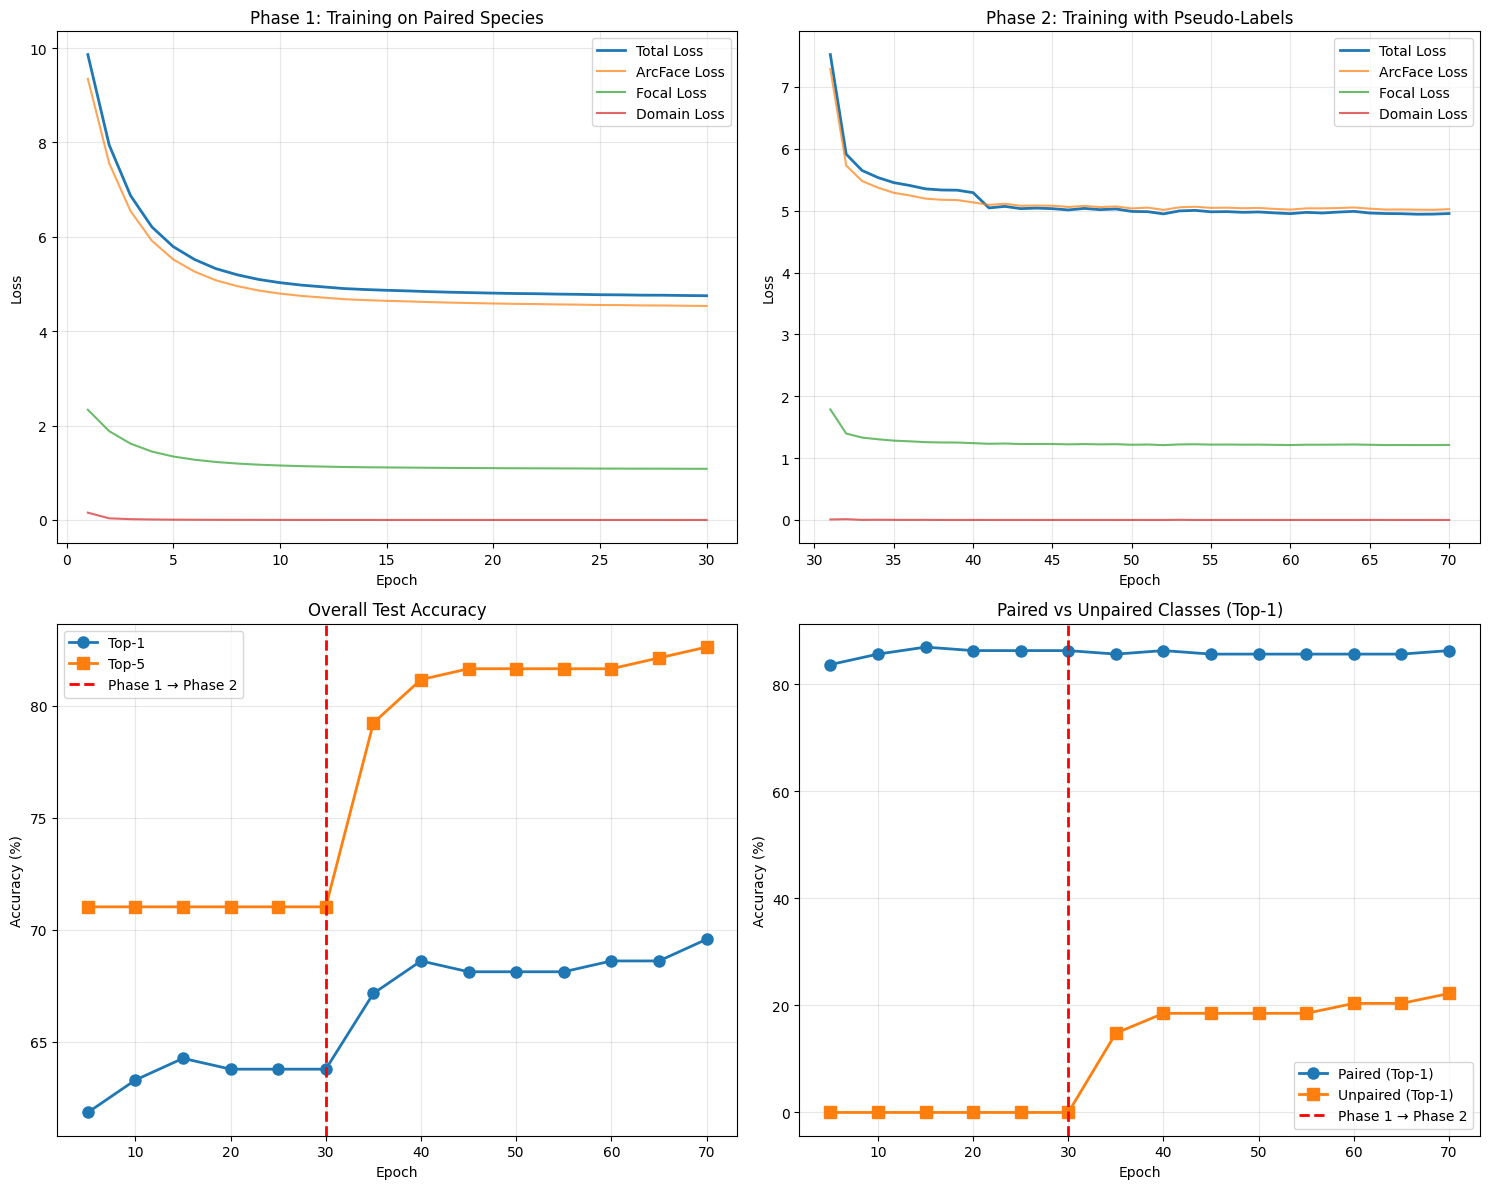

In [22]:
# @title Visualize Training History
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot Phase 1 losses
ax1 = axes[0, 0]
phase1_epochs = list(range(1, len(training_history['phase1_losses']) + 1))
ax1.plot(phase1_epochs, [d['total'] for d in training_history['phase1_losses']], label='Total Loss', linewidth=2)
ax1.plot(phase1_epochs, [d['arcface'] for d in training_history['phase1_losses']], label='ArcFace Loss', alpha=0.7)
ax1.plot(phase1_epochs, [d['focal'] for d in training_history['phase1_losses']], label='Focal Loss', alpha=0.7)
ax1.plot(phase1_epochs, [d['domain'] for d in training_history['phase1_losses']], label='Domain Loss', alpha=0.7)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Phase 1: Training on Paired Species')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot Phase 2 losses
ax2 = axes[0, 1]
phase2_epochs = list(range(PHASE1_EPOCHS + 1, PHASE1_EPOCHS + len(training_history['phase2_losses']) + 1))
ax2.plot(phase2_epochs, [d['total'] for d in training_history['phase2_losses']], label='Total Loss', linewidth=2)
ax2.plot(phase2_epochs, [d['arcface'] for d in training_history['phase2_losses']], label='ArcFace Loss', alpha=0.7)
ax2.plot(phase2_epochs, [d['focal'] for d in training_history['phase2_losses']], label='Focal Loss', alpha=0.7)
ax2.plot(phase2_epochs, [d['domain'] for d in training_history['phase2_losses']], label='Domain Loss', alpha=0.7)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Phase 2: Training with Pseudo-Labels')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot accuracies
ax3 = axes[1, 0]
eval_epochs = [i * 5 for i in range(1, len(training_history['accuracies']) + 1)]
ax3.plot(eval_epochs, [r['top1'] for r in training_history['accuracies']], 'o-', label='Top-1', linewidth=2, markersize=8)
ax3.plot(eval_epochs, [r['top5'] for r in training_history['accuracies']], 's-', label='Top-5', linewidth=2, markersize=8)
ax3.axvline(x=PHASE1_EPOCHS, color='red', linestyle='--', label='Phase 1 → Phase 2', linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy (%)')
ax3.set_title('Overall Test Accuracy')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot paired vs unpaired accuracy
ax4 = axes[1, 1]
ax4.plot(eval_epochs, [r['paired_top1'] for r in training_history['accuracies']], 'o-', label='Paired (Top-1)', linewidth=2, markersize=8)
ax4.plot(eval_epochs, [r['unpaired_top1'] for r in training_history['accuracies']], 's-', label='Unpaired (Top-1)', linewidth=2, markersize=8)
ax4.axvline(x=PHASE1_EPOCHS, color='red', linestyle='--', label='Phase 1 → Phase 2', linewidth=2)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy (%)')
ax4.set_title('Paired vs Unpaired Classes (Top-1)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'training_history.png'), dpi=150, bbox_inches='tight')
plt.show()

In [23]:
# @title Save Results Summary
results_summary = {
    'best_epoch': checkpoint['epoch'],
    'best_accuracy': best_accuracy,
    'final_results': final_results,
    'training_config': {
        'phase1_epochs': PHASE1_EPOCHS,
        'phase2_epochs': PHASE2_EPOCHS,
        'pseudo_confidence': PSEUDO_CONFIDENCE,
        'lambda_focal': 0.2,
        'lambda_adv': 0.3,
        'arcface_s': 20.0,
        'arcface_m': 0.3,
        'focal_alpha': 0.25,
        'focal_gamma': 2.0
    },
    'dataset_info': {
        'num_classes': num_classes,
        'total_train_samples': len(train_features),
        'classes_with_pairs': len(classes_with_pairs),
        'classes_without_pairs': len(classes_without_pairs),
        'test_samples': len(test_features)
    }
}

with open(os.path.join(RESULTS_PATH, 'results_summary.json'), 'w') as f:
    json.dump(results_summary, f, indent=4)

print("\nResults saved to:", RESULTS_PATH)
print("\nTraining completed successfully!")


Results saved to: /content/drive/MyDrive/ML Project/results_pseudo-labelling/

Training completed successfully!


In [24]:
# @title Generate Predictions for Submission
def generate_predictions(model, test_features, test_paths, output_file, idx_to_label):
    """Generate predictions file for submission"""
    model.eval()

    predictions = []

    with torch.no_grad():
        batch_size = 64
        for i in range(0, len(test_features), batch_size):
            batch_features = test_features[i:i+batch_size].to(device)
            class_output, _ = model(batch_features, lambda_adv=0.0)

            # Get top-5 predictions
            _, top5_preds = torch.topk(class_output, 5, dim=1)
            predictions.append(top5_preds.cpu())

    predictions = torch.cat(predictions, dim=0)

    # Convert remapped predictions back to original labels
    predictions_original = torch.zeros_like(predictions)
    for i in range(predictions.shape[0]):
        for j in range(predictions.shape[1]):
            remapped_idx = predictions[i, j].item()
            if remapped_idx in idx_to_label:
                predictions_original[i, j] = idx_to_label[remapped_idx]
            else:
                predictions_original[i, j] = -1

    # Write to file
    with open(output_file, 'w') as f:
        for path, preds in zip(test_paths, predictions_original):
            pred_str = ' '.join(map(str, preds.tolist()))
            f.write(f"{path} {pred_str}\n")

    print(f"Predictions saved to: {output_file}")

# Generate predictions
predictions_file = os.path.join(RESULTS_PATH, 'predictions.txt')
generate_predictions(model, test_features, test_paths, predictions_file, idx_to_label)

Predictions saved to: /content/drive/MyDrive/ML Project/results_pseudo-labelling/predictions.txt


In [25]:
# @title Analyze Per-Class Performance
def analyze_per_class_performance(model, test_features, test_paths, test_groundtruth, classes_with_pairs, classes_without_pairs, idx_to_label):
    """Analyze performance for each class"""
    model.eval()

    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    with torch.no_grad():
        batch_size = 64
        all_predictions = []

        for i in range(0, len(test_features), batch_size):
            batch_features = test_features[i:i+batch_size].to(device)
            class_output, _ = model(batch_features, lambda_adv=0.0)
            _, top1_pred = torch.max(class_output, dim=1)
            all_predictions.append(top1_pred.cpu())

        all_predictions = torch.cat(all_predictions, dim=0)

    # Convert remapped predictions back to original labels
    all_predictions_original = torch.tensor([
        idx_to_label.get(pred.item(), -1) for pred in all_predictions
    ])

    # Calculate per-class accuracy
    for path, pred in zip(test_paths, all_predictions_original):
        true_label = test_groundtruth.get(path, -1)
        if true_label != -1:
            class_total[true_label] += 1
            if pred.item() == true_label:
                class_correct[true_label] += 1

    # Separate paired and unpaired classes
    paired_accuracies = []
    unpaired_accuracies = []

    print("\n--- Per-Class Performance ---")
    print(f"{'Class ID':<10} {'Type':<10} {'Correct':<10} {'Total':<10} {'Accuracy':<10}")
    print("-" * 60)

    for class_id in sorted(class_total.keys()):
        correct = class_correct[class_id]
        total = class_total[class_id]
        accuracy = correct / total * 100 if total > 0 else 0

        class_type = "Paired" if class_id in classes_with_pairs else "Unpaired"

        if class_type == "Paired":
            paired_accuracies.append(accuracy)
        else:
            unpaired_accuracies.append(accuracy)

        print(f"{class_id:<10} {class_type:<10} {correct:<10} {total:<10} {accuracy:<10.2f}%")

    # Summary statistics
    print("\n--- Summary Statistics ---")
    if paired_accuracies:
        print(f"Paired classes - Mean: {np.mean(paired_accuracies):.2f}%, Std: {np.std(paired_accuracies):.2f}%")
    if unpaired_accuracies:
        print(f"Unpaired classes - Mean: {np.mean(unpaired_accuracies):.2f}%, Std: {np.std(unpaired_accuracies):.2f}%")

    return class_correct, class_total

# Analyze per-class performance
class_correct, class_total = analyze_per_class_performance(
    model, test_features, test_paths, test_groundtruth,
    classes_with_pairs, classes_without_pairs, idx_to_label
)


--- Per-Class Performance ---
Class ID   Type       Correct    Total      Accuracy  
------------------------------------------------------------
12254      Unpaired   2          2          100.00    %
12518      Paired     3          3          100.00    %
12910      Paired     3          3          100.00    %
12922      Paired     2          2          100.00    %
13276      Unpaired   0          1          0.00      %
13325      Unpaired   0          1          0.00      %
13330      Paired     2          2          100.00    %
13370      Paired     3          3          100.00    %
14353      Paired     2          2          100.00    %
14401      Unpaired   0          1          0.00      %
15014      Unpaired   0          1          0.00      %
15318      Paired     2          2          100.00    %
15330      Unpaired   0          1          0.00      %
15355      Paired     0          2          0.00      %
19165      Paired     3          3          100.00    %
19489      Pa

Computing t-SNE... (this may take a few minutes)


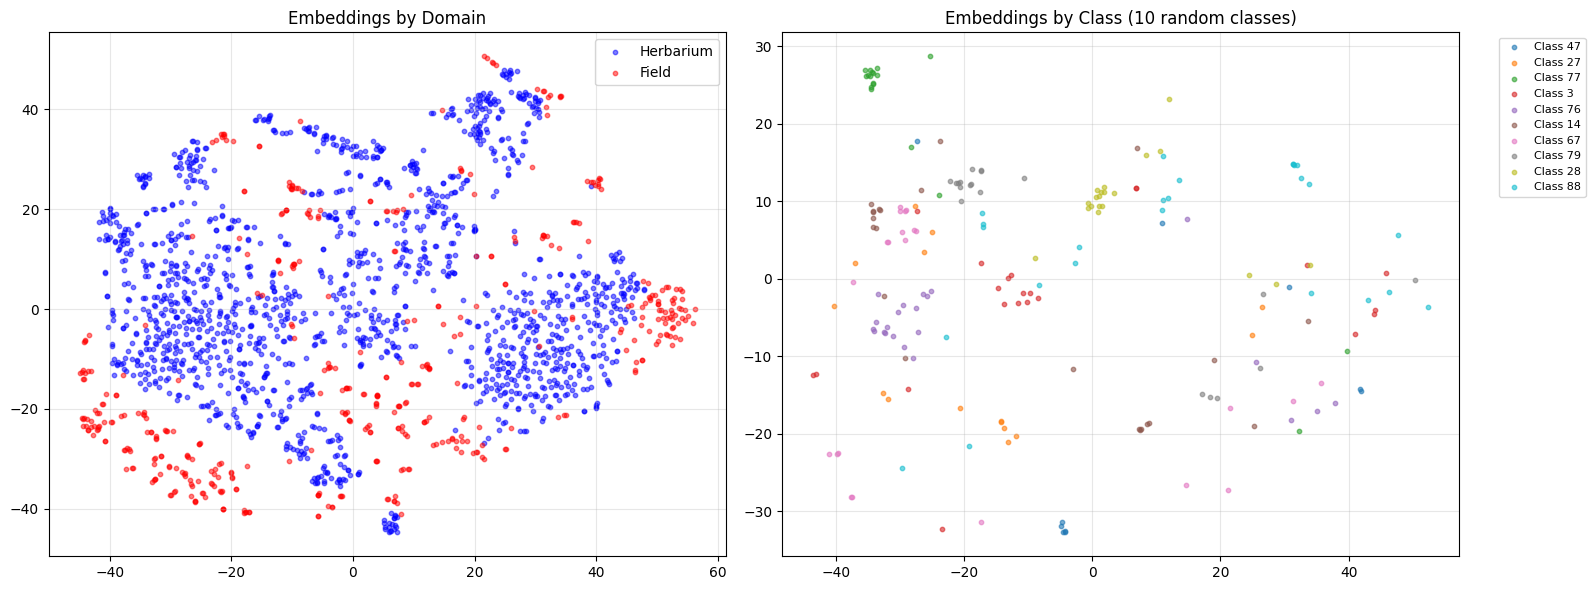

In [26]:
# @title Visualize Embedding Space (t-SNE)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_embeddings(features, labels, domains, title="Embedding Space Visualization"):
    """Visualize embeddings using t-SNE"""
    print("Computing t-SNE... (this may take a few minutes)")

    # Sample if too many points
    max_samples = 2000
    if len(features) > max_samples:
        indices = np.random.choice(len(features), max_samples, replace=False)
        features = features[indices]
        labels = labels[indices]
        domains = domains[indices]

    # Compute t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_2d = tsne.fit_transform(features.numpy())

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot by domain
    herbarium_mask = domains.numpy() == 0
    field_mask = domains.numpy() == 1

    ax1.scatter(embeddings_2d[herbarium_mask, 0], embeddings_2d[herbarium_mask, 1],
                c='blue', label='Herbarium', alpha=0.5, s=10)
    ax1.scatter(embeddings_2d[field_mask, 0], embeddings_2d[field_mask, 1],
                c='red', label='Field', alpha=0.5, s=10)
    ax1.set_title('Embeddings by Domain')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot by class (sample 10 classes for clarity)
    unique_labels = np.unique(labels.numpy())
    sample_classes = np.random.choice(unique_labels, min(10, len(unique_labels)), replace=False)

    colors = plt.cm.tab10(np.linspace(0, 1, len(sample_classes)))
    for i, class_id in enumerate(sample_classes):
        mask = labels.numpy() == class_id
        ax2.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                   c=[colors[i]], label=f'Class {class_id}', alpha=0.6, s=10)

    ax2.set_title('Embeddings by Class (10 random classes)')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, 'embedding_visualization.png'), dpi=150, bbox_inches='tight')
    plt.show()

# Visualize embeddings
visualize_embeddings(train_features, train_labels, train_domains)

In [27]:
# @title Print Final Summary
print("\n" + "="*80)
print("TRAINING COMPLETE - FINAL SUMMARY")
print("="*80)
print(f"\nBest Model:")
print(f"  - Epoch: {checkpoint['epoch']}")
print(f"  - Top-1 Accuracy: {final_results['top1']:.2f}%")
print(f"  - Top-5 Accuracy: {final_results['top5']:.2f}%")

print(f"\nPerformance on Classes WITH Pairs:")
print(f"  - Top-1 Accuracy: {final_results['paired_top1']:.2f}%")
print(f"  - Top-5 Accuracy: {final_results['paired_top5']:.2f}%")

print(f"\nPerformance on Classes WITHOUT Pairs:")
print(f"  - Top-1 Accuracy: {final_results['unpaired_top1']:.2f}%")
print(f"  - Top-5 Accuracy: {final_results['unpaired_top5']:.2f}%")

print(f"\nFiles saved to: {RESULTS_PATH}")
print(f"  - Model weights: {WEIGHTS_PATH}")
print(f"  - Results summary: {os.path.join(RESULTS_PATH, 'results_summary.json')}")
print(f"  - Predictions: {os.path.join(RESULTS_PATH, 'predictions.txt')}")
print(f"  - Training history plot: {os.path.join(RESULTS_PATH, 'training_history.png')}")
print(f"  - Embedding visualization: {os.path.join(RESULTS_PATH, 'embedding_visualization.png')}")

print("\n" + "="*80)
print("All done! 🎉")
print("="*80)


TRAINING COMPLETE - FINAL SUMMARY

Best Model:
  - Epoch: 70
  - Top-1 Accuracy: 69.57%
  - Top-5 Accuracy: 82.61%

Performance on Classes WITH Pairs:
  - Top-1 Accuracy: 86.27%
  - Top-5 Accuracy: 96.08%

Performance on Classes WITHOUT Pairs:
  - Top-1 Accuracy: 22.22%
  - Top-5 Accuracy: 44.44%

Files saved to: /content/drive/MyDrive/ML Project/results_pseudo-labelling/
  - Model weights: /content/drive/MyDrive/ML Project/pseudo-labelling_model_weights.pth
  - Results summary: /content/drive/MyDrive/ML Project/results_pseudo-labelling/results_summary.json
  - Predictions: /content/drive/MyDrive/ML Project/results_pseudo-labelling/predictions.txt
  - Training history plot: /content/drive/MyDrive/ML Project/results_pseudo-labelling/training_history.png
  - Embedding visualization: /content/drive/MyDrive/ML Project/results_pseudo-labelling/embedding_visualization.png

All done! 🎉
